In [1]:
"""
TBD need to know if position risk has been reduced, otherwise don't generate orders for symbol

Option 2:
    - Store initial_size and current_size of position
    - if current_size is some criteria below the initial size, then risk is reduced
    - filter out stocks where criteria is not met

Position Table Generation:
1. Each row in the position table shall obtain the following info:
    - Symbol name
    - initial size
    - entry date?
    - direction?
    -

Order Table Generation:
1.) Order Table generation shall follow this procedure:
    1. Retrieve data for current open positions
    2. For each open position:
        1. if at least one of the following is true:
            TRAIL_STOP || STOP || TARGET_EXIT || FRENCH_STOP || REGIME_END
            1. Generate an order entry, where type is the first discovered reason for entry creation
    3. For each symbol, create order entry if:
        symbol not in order_table && risk_reduced is True
    4.


Order Table Output:
1.) The following data shall be stored in the order_table, sorted by close type first. It may be a view of a larger table:
    Symbol,
    direction of trade,
    position size (dollars or shares),
    type: [
        ENTRY,
        TRAIL_STOP,
        STOP,
        TARGET_EXIT,
        FRENCH_STOP,
        REGIME_END
    ]


2.) Output of the order table shall be sorted by type, with the following priority:
    1. STOP
    2. TRAIL_STOP
    3. TARGET_EXIT
    4. FRENCH_STOP
    5. REGIME_END
    6. ENTRY



2.)
Entries/Exits in the order table shall be generated from
"""
import scripts
import data_manager.utils as sbtu
import tda_access.access as tda
import json
import scripts.account_data as sad
import tda_access.access as taa
import data_manager.utils as dmu
import pandas as pd
import pathlib
from data_manager import scanner

In [2]:

# init client and tables
regime_df = pd.read_excel(pathlib.Path('..') / 'data' / 'regimes.xlsx')

with open('scanner_config.json') as fp:
    scanner_args = json.load(fp)

(
    website,
    start,
    end,
    vlty_n,
    dist_pct,
    retrace_pct,
    threshold,
    dgt,
    d_vol,
    r_vol,
    lvl,
    bm_ticker,
    bm_col,
    ccy_col,
    window,
    st,
    lt,
    save_ticker_df,
    save_last_row_df,
    save_regime_df
) = list(scanner_args.values())
fast = st
slow = lt
regime_cols = [
    'rg','rrg',
    'smaC'+str(st)+str(lt),'smar'+str(st)+str(lt), 'boHL'+str(slow),
    'borr'+str(slow),'ttH'+str(fast)+'L'+str(slow),'ttr'+str(fast)+'r'+str(slow)
]
groupby_cols = ['score', 'delta'] + regime_cols
sort_key = ['GICS Sector','GICS Sub-Industry']
grouped = regime_df.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= ['GICS Sector','score'])
sub_sectors = list(grouped.loc[
    ((grouped.delta >= 0.5) & (grouped.rrg > 0)) |
    ((grouped.delta <= -0.5) & (grouped.rrg < 0))
].index.get_level_values(1))

td_client = taa.TdBrokerClient.init_from_json('..\\data_args\\credentials.json')

In [64]:
_strategy_lookup, tx_tables, price_histories, bench = sad.main(
    td_client=td_client,
    sub_sectors=sub_sectors,
    multiprocess=True
)

MMM
ATVI
APD
AME
AON
AJG
BRO
BF.B
CAT
SCHW
CTAS
STZ
CPRT
CVS
DE
DG
DLTR
ETN
EA
EMR
RE
GNRC
GE
GS
HD
HON
HST
JBHT
LH
LDOS
LIN
LOW
MMC
MS
NUE
ODFL
PCAR
DGX
RJF
ROK
SYY
TTWO
TGT
URI
VICI
WAB
WTW
d


In [65]:
order_table = pd.read_excel(pathlib.Path('..') / 'data' / 'order_table.xlsx', index_col=0)

In [66]:
order_table

,symbol,stop_px,en_px,r_pct,target,shares,en_px_abs,GICS Sub-Industry,nominal_size,clamped_shares
0,MMM,107.834594,106.524770,-0.012296,104.560035,-142,120.7400,Industrial Conglomerates,-17145.0800,-161
1,ATVI,63.802687,64.246594,0.006909,64.912455,420,72.8200,Interactive Home Entertainment,24829.7700,386
2,APD,216.802096,223.601439,0.030408,233.800453,28,253.4400,Industrial Gases,7096.3200,31
3,AME,106.903996,109.418602,0.022982,113.190512,75,124.0200,Electrical Components & Equipment,9301.5000,85
4,AON,243.447142,247.925507,0.018063,254.643054,42,281.0100,Insurance Brokers,11802.4200,47
5,AJG,154.949864,156.037526,0.006971,157.669018,172,176.8600,Insurance Brokers,24829.7700,159
6,BRO,48.054323,49.618627,0.031527,51.965083,120,56.2400,Insurance Brokers,6748.8000,136
7,BF.B,64.140434,59.314728,-0.081358,52.076170,-38,67.2300,Distillers & Vintners,-2554.7400,-44
8,CAT,189.659603,173.832827,-0.091046,150.092662,-11,197.0300,Construction Machinery & Heavy Trucks,-2167.3300,-13
9,SCHW,62.387732,65.075924,0.041309,69.108212,70,73.7600,Investment Banking & Brokerage,5163.2000,79


In [67]:
symbol = 'CPRT'
od = order_table[order_table.symbol == symbol]
(27.2 - od.en_px) / (od.en_px * od.r_pct)

12    19.043922
dtype: float64

In [68]:
epd = _strategy_lookup[symbol].enhanced_price_data.copy()

In [69]:
_pt = _strategy_lookup[symbol].peak_table.copy()
# _pt = pda.PeakTable(_pt)
# _pt = _pt.unpivot(_symbol_data.index)
# _pt = _pt.loc[~_pt.index.duplicated(keep='first')]
def filter_duplicates(_sw):
    return _sw.loc[~_sw.index.duplicated(keep='first')]

_shi_px = _pt.loc[(_pt.type == -1)].set_index('end')
_slo_px = _pt.loc[(_pt.type == 1)].set_index('end')
_shis = []
_slos = []
for i in range(1, 5):
    _shis.append(
        _shi_px.loc[(_shi_px.lvl == i)]
    )
    _shis[i-1] = filter_duplicates(_shis[i-1])
    _slos.append(
        _slo_px.loc[(_slo_px.lvl == i)]
    )
    _slos[i-1] = filter_duplicates(_slos[i-1])
    epd[f'hi{i}_lag'] = _shis[i-1].en_px
    epd[f'lo{i}_lag'] = _slos[i-1].en_px

epd['hi_band'] = epd.close.rolling(256).max()
epd['lo_band'] = epd.close.rolling(256).min()
epd['trade_range'] = epd.hi_band - epd.lo_band
epd['40pct_band'] = epd.trade_range * .4 + epd.lo_band
epd['61pct_band'] = epd.trade_range * .61 + epd.lo_band

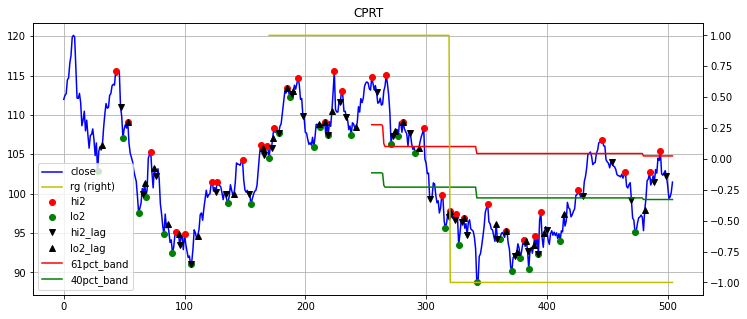

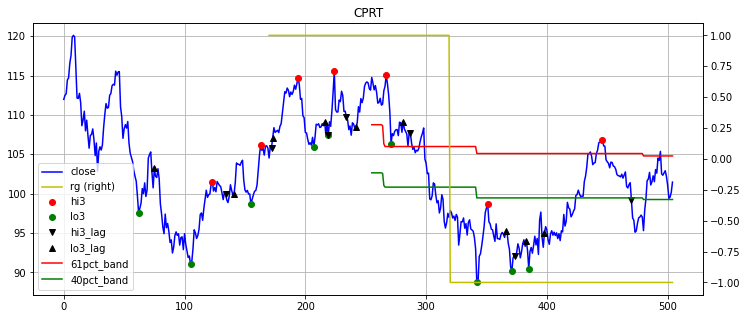

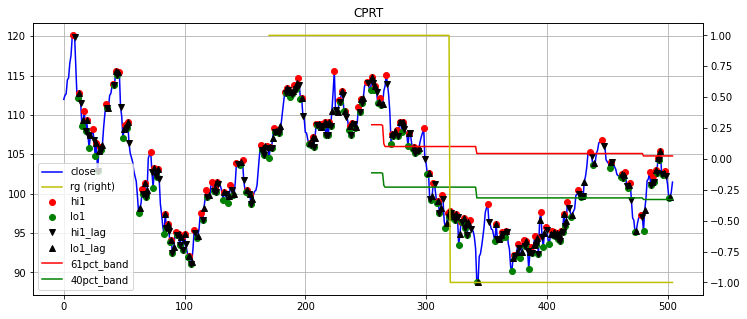

In [70]:
def plot(lvl):
    epd[[
        'close',
        'rg',
        f'hi{lvl}',
        f'lo{lvl}',
        f'hi{lvl}_lag',
        f'lo{lvl}_lag',
        '61pct_band',
        '40pct_band'
    ]].plot(
        style=[
            'b',
            'y',
            'ro',
            'go',
            'kv',
            'k^',
            'r-',
            'g-'
        ], figsize=[12, 5], secondary_y='rg', grid=True, title=symbol)

# plot(4)
plot(2)
plot(3)
plot(1)